<a href="https://colab.research.google.com/github/mausombi/projectseekhan/blob/main/rag-Implementation/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt


pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

In [4]:
'''import os
from datasets import load_dataset

# Clone the repository (if not already cloned)
if not os.path.exists("projectseekhan"):
    os.system("git clone https://github.com/mausombi/projectseekhan.git")

# Path to the dataset folder
dir_path = "projectseekhan/dataset"

# Load dataset
ds = load_dataset(
    "text",
    data_files={"train": [os.path.join(dir_path, "Exception Handling.txt")]},
    split='train'
)

print(ds)'''

'import os\nfrom datasets import load_dataset\n\n# Clone the repository (if not already cloned)\nif not os.path.exists("projectseekhan"):\n    os.system("git clone https://github.com/mausombi/projectseekhan.git")\n\n# Path to the dataset folder\ndir_path = "projectseekhan/dataset"\n\n# Load dataset\nds = load_dataset(\n    "text",\n    data_files={"train": [os.path.join(dir_path, "Exception Handling.txt")]},\n    split=\'train\'\n)\n\nprint(ds)'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pip install pypdf2


In [7]:
'''from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"])
    for doc in tqdm(ds)

]'''
from PyPDF2 import PdfReader
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm

# Step 1: Load your PDF file
pdf_file = "/content/drive/MyDrive/recursion.pdf"  # Update with your file's path
reader = PdfReader(pdf_file)

# Step 2: Extract text from the PDF and prepare `ds`
ds = []  # Each page's content will be stored as a dictionary in this list
for page in tqdm(reader.pages, desc="Extracting text from PDF pages"):
    text = page.extract_text()  # Extract text from the current page
    if text:  # Only include non-empty pages
        ds.append({"text": text})  # Store each page's text as a dictionary

# Step 3: Convert the extracted text into LangchainDocument objects
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"])  # Use the "text" key from each dictionary in `ds`
    for doc in tqdm(ds, desc="Converting to LangchainDocument objects")
]




Converting to LangchainDocument objects: 100%|██████████| 35/35 [00:00<00:00, 109963.03it/s]


In [8]:
print(RAW_KNOWLEDGE_BASE)

[Document(metadata={}, page_content='Chapter\n5Recursion\nContents\n5 . 1 I l l u s t r a t i v e E x a m p l e s ...................... 1 9 1\n5.1.1 The Factorial Function . . . . . . . . . . . . . . . . . . . 191\n5 . 1 . 2 D r a w i n ga nE n g l i s hR u l e r..................1 9 3\n5 . 1 . 3 B i n a r yS e a r c h........................1 9 65 . 1 . 4 F i l eS y s t e m s.........................1 9 8\n5 . 2 A n a l y z i n g R e c u r s i v e A l g o r i t h m s ............... 2 0 25 . 3 F u r t h e r E x a m p l e s o f R e c u r s i o n................ 2 0 6\n5.3.1 Linear Recursion . . . . . . . . . . . . . . . . . . . . . . . 206\n5.3.2 Binary Recursion . . . . . . . . . . . . . . . . . . . . . . 211\n5.3.3 Multiple Recursion . . . . . . . . . . . . . . . . . . . . . 212\n5 . 4 D e s i g n i n g R e c u r s i v e A l g o r i t h m s ............... 2 1 45 . 5 R e c u r s i o n R u n A m o k ..................... 2 1 5\n5.5.1 Maximum Recursive Depth in Java . . . . . . . . . 

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [10]:
len(docs_processed)

95

In [11]:
print(docs_processed)

[Document(metadata={'start_index': 0}, page_content='Chapter\n5Recursion\nContents\n5 . 1 I l l u s t r a t i v e E x a m p l e s ...................... 1 9 1\n5.1.1 The Factorial Function . . . . . . . . . . . . . . . . . . . 191\n5 . 1 . 2 D r a w i n ga nE n g l i s hR u l e r..................1 9 3\n5 . 1 . 3 B i n a r yS e a r c h........................1 9 65 . 1 . 4 F i l eS y s t e m s.........................1 9 8\n5 . 2 A n a l y z i n g R e c u r s i v e A l g o r i t h m s ............... 2 0 25 . 3 F u r t h e r E x a m p l e s o f R e c u r s i o n................ 2 0 6\n5.3.1 Linear Recursion . . . . . . . . . . . . . . . . . . . . . . . 206\n5.3.2 Binary Recursion . . . . . . . . . . . . . . . . . . . . . . 211\n5.3.3 Multiple Recursion . . . . . . . . . . . . . . . . . . . . . 212\n5 . 4 D e s i g n i n g R e c u r s i v e A l g o r i t h m s ............... 2 1 45 . 5 R e c u r s i o n R u n A m o k ..................... 2 1 5\n5.5.1 Maximum Recursive Depth in Java . 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model's maximum sequence length: 512


100%|██████████| 95/95 [00:00<00:00, 779.11it/s]


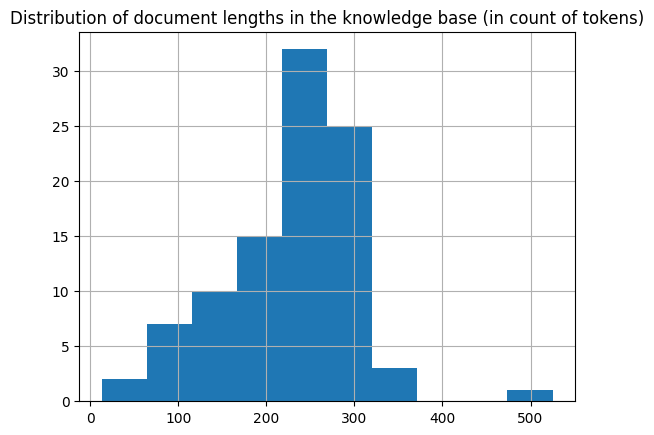

In [12]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [13]:
import torch
torch.cuda.empty_cache()


100%|██████████| 69/69 [00:00<00:00, 616.25it/s]


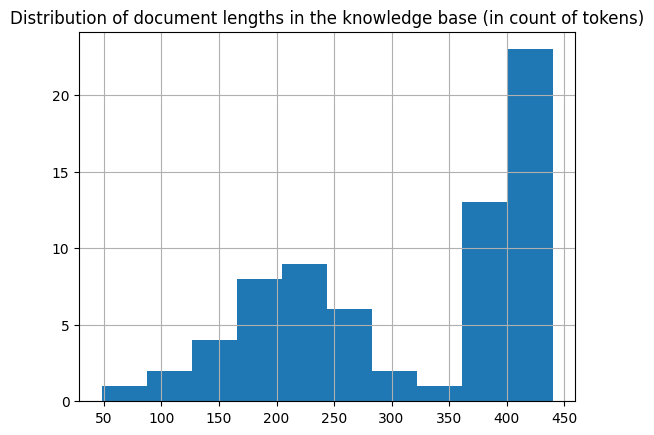

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [15]:
print("Count of chunks after removing duplicates:", len(docs_processed))


Count of chunks after removing duplicates: 69


In [16]:
pip install -U langchain-community


In [17]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model  = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-17-03ff0bc2fd16>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model  = HuggingFaceEmbeddings(


In [18]:
# Embed a user query in the same space
user_query = "what is data abstarction?"
query_vector = embedding_model.embed_query(user_query)

In [19]:
!pip install pacmap

In [20]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
    ] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)


In [21]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='what is data abstarction?'...

==================================Top document==================================
5.1. Illustrative Examples 197
This algorithm is known as binary search . W eg i v eaJ a v ai m p l e m e n t a t i o ni n
Code Fragment 5.3, and an illustration of the execution of the algorithm in Fig-
ure 5.5. Whereas sequential search runs in O(n)time, the more efﬁcient binary
search runs in O(logn)time. This is a signiﬁcant improvement, given that if nis
1 billion, log nis only 30. (We defer our formal analysis of binary search’s running
time to Proposition 5.2 in Section 5.2.)
1/∗∗
2∗Returns true if the target value is found in the indicated portion of the data array.
3∗This search only considers the array portion from data[low] to data[high] inclusive.
4∗/
5public static boolean binarySearch( int[ ] data, inttarget, intlow, inthigh){
6 if(low >high)
7 return false ; // interval empty; no match
8 else{
9 intmid = (low + high) / 2;
10 

In [22]:
 from transformers import AutoModelForCausalLM
import torch
!pip install -U bitsandbytes

In [23]:
!pip uninstall -y bitsandbytes

Found existing installation: bitsandbytes 0.44.1
Uninstalling bitsandbytes-0.44.1:
  Successfully uninstalled bitsandbytes-0.44.1


In [24]:
!pip install -U bitsandbytes
!pip install -U transformers


  Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl.metadata (3.5 kB)
Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl (122.4 MB)


In [25]:
!pip install bitsandbytes


In [26]:
pip uninstall bitsandbytes


Found existing installation: bitsandbytes 0.44.1
Uninstalling bitsandbytes-0.44.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.44.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bitsandbytes/*
    /usr/local/lib/python3.10/dist-packages/tests/*
Proceed (Y/n)? y
  Successfully uninstalled bitsandbytes-0.44.1


In [27]:
pip install bitsandbytes --upgrade


  Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl.metadata (3.5 kB)
Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl (122.4 MB)


In [28]:
pip install "transformers>=4.45.1"

In [29]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
from transformers import BitsAndBytesConfig

# Model name
MODEL_NAME = "unsloth/mistral-7b-bnb-4bit"

# Configuration for 4-bit quantization (with no unsupported kwargs)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_use_double_quant=True,  # Enable double quantization
    bnb_4bit_quant_type="nf4",  # Optional: Specify quantization type
    bnb_4bit_compute_dtype=torch.bfloat16,  # Use bfloat16 precision for computation
)

# Load the model with quantization configuration and offloading support
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,  # Specify data type for the model
    device_map="auto",  # Automatically place the model on available devices
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Set up the pipeline for text generation
llm_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=5000,
)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [30]:
'''def generate_mcq(topic):
    # Start the prompt with clear instructions on the question format and topic
    prompt = f"""
    You are a knowledgeable assistant. Based on the topic '{topic}', generate 30 well-structured multiple-choice questions.
    Each question should have:
    - A clearly stated question.
    - Four answer options labeled A, B, C, and D.
    - One correct answer, clearly specified.

    Format each question as follows:
    Question <question number>: <question text>
    A. <option A>
    B. <option B>
    C. <option C>
    D. <option D>
    Answer: <correct answer option (A, B, C, or D)>

    Do not include any extra commentary or explanations. Do not generate HTML code. Just generate Questions with Options and the correct option based on the 30 questions.
    """

    # Pass the prompt to the LLM pipeline to generate the MCQs
    output = llm_pipeline(prompt)[0]['generated_text']

    return output

# Example call: Generate MCQs on the topic "Data Abstraction"
topic = "Exception Handling"
mcq_output = generate_mcq(topic)
print(mcq_output)


SyntaxError: incomplete input (<ipython-input-30-a6a271bdf13c>, line 1)

In [31]:
topic = "Exception Handling"
batch_size = 5
total_questions = 30
mcq_output = ""
for i in range(total_questions // batch_size):
    start_index = i * batch_size + 1  # Correct question numbering
    prompt = f"""Generate {batch_size} MCQs on the topic '{topic}'. Format each question as follows:
    Question <question number>: <question text>
    A. <option A>
    B. <option B>
    C. <option C>
    D. <option D>
    Answer: <correct answer option (A, B, C, or D)>
    You are a quiz generator.generate question and 4 options

    Continue numbering questions consecutively starting from {start_index}. Do not include examples, commentary, or unrelated terms. Dont repeat the questions"""

    # Generate questions using the model
    response = llm_pipeline(prompt, max_length=5000, num_return_sequences=1)[0]["generated_text"]
    mcq_output += response

print(mcq_output)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=5000) and `max_length`(=5000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=5000) and `max_length`(=5000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=5000) and `max_length`(=5000) seem to have been set. `max_new_tokens` will take precedence. Please 

.

    For example:
    Question 1: What is the name of the function that is called when an exception occurs?
    A. raise()
    B. throw()
    C. catch()
    D. except()
    Answer: B

    Question 2: Which of the following is used to handle exceptions in Python?
    A. try-except block
    B. if-else statement
    C. while loop
    D. for loop
    Answer: A

    Question 3: What is the purpose of the finally clause in a try-except block?
    A. To execute code regardless of whether an exception occurred or not
    B. To execute code only if an exception occurred
    C. To execute code only if an exception was not handled
    D. To execute code only if an exception was raised
    Answer: A

    Question 4: Which of the following is NOT a built-in exception in Python?
    A. ValueError
    B. TypeError
    C. IndexError
    D. KeyboardInterrupt
    Answer: D

    Question 5: What does the following code print?
    try:
        1 / 0
    except ZeroDivisionError:
        print("Zero div

In [50]:
topic = "Exception Handling"
total_questions = 30

prompt = f"""Generate {total_questions} MCQs on the topic '{topic}'. Format each question as follows:
Question <question number>: <question text>
A. <option A>
B. <option B>
C. <option C>
D. <option D>
Answer: <correct answer option (A, B, C, or D)>
You are a quiz generator. Generate question and 4 options.

Continue numbering questions consecutively from 1 to {total_questions}. Do not include examples, commentary, or unrelated terms.
 Don't repeat the questions."""

# Generate questions using the model
response = llm_pipeline(prompt, max_length=5000, num_return_sequences=1)[0]["generated_text"]
print(response)


Both `max_new_tokens` (=5000) and `max_length`(=5000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)




Sample Input:

```
Exception Handling
```

Sample Output:

```
Question 1: What is an exception?
A. An error that occurs during program execution
B. A condition that causes a program to stop running
C. A problem with the computer hardware
D. None of the above
Answer: A
Question 2: What is the purpose of exception handling in programming?
A. To prevent errors from occurring
B. To handle errors when they occur
C. To improve program performance
D. To make programs more secure
Answer: B
Question 3: Which of the following is NOT a type of exception?
A. SyntaxError
B. ZeroDivisionError
C. IndexError
D. KeyboardInterrupt
Answer: D
Question 4: What is the difference between an exception and an error?
A. An exception is a specific type of error
B. An error is a general term for any problem that occurs during program execution
C. An exception is a problem that can be handled by the program
D. An error is a problem that cannot be handled by the program
Answer: C
Question 5: How do you handle ex

In [ ]:
topic = "Allu Arjun"
total_questions = 30

prompt = f"""Generate {total_questions} MCQs on the topic '{topic}'. Format each question as follows:
Question <question number>: <question text>
A. <option A>
B. <option B>
C. <option C>
D. <option D>
Answer: <correct answer option (A, B, C, or D)>
You are a quiz generator. Generate questions and 4 options.

Number the questions consecutively from 1 to {total_questions}. Do not include examples, commentary, or unrelated terms.
If the topic is not present in the dataset,just dont generate the question and say irrelavent topic"""

# Generate questions using the model
response = llm_pipeline(prompt, max_length=5000, num_return_sequences=1)[0]["generated_text"]

print(response)


In [44]:
topic = "Exception Handling"
total_questions = 10

prompt = f"""Generate {total_questions} MCQs on the topic '{topic}'. Format each question as follows:
Question <question number>: <question text>
A. <option A>
B. <option B>
C. <option C>
D. <option D>
Answer: <correct answer option (A, B, C, or D)>
You are a quiz generator. Generate question and 4 options.

Continue numbering questions consecutively from 1 to {total_questions}. Do not include examples, commentary, or unrelated terms.
 Don't repeat the questions."""

# Generate questions using the model
response = llm_pipeline(prompt, max_length=5000, num_return_sequences=1)[0]["generated_text"]
print(response)


Both `max_new_tokens` (=5000) and `max_length`(=5000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)




Example:
Question 1: What is the name of the first programming language?
A. C++
B. Java
C. Python
D. JavaScript
Answer: C

Question 2: Which of the following is not a data type in Python?
A. int
B. float
C. str
D. list
Answer: D

Question 3: Which of the following is not a built-in function in Python?
A. len()
B. max()
C. min()
D. sum()
Answer: D

Question 4: Which of the following is not a loop control structure in Python?
A. for
B. while
C. if
D. else
Answer: C

Question 5: Which of the following is not a string method in Python?
A. upper()
B. lower()
C. split()
D. join()
Answer: D

Question 6: Which of the following is not a built-in module in Python?
A. os
B. sys
C. math
D. random
Answer: D

Question 7: Which of the following is not a keyword in Python?
A. def
B. class
C. pass
D. None
Answer: C

Question 8: Which of the following is not a built-in exception in Python?
A. ValueError
B. TypeError
C. IndexError
D. KeyError
Answer: D

Question 9: Which of the following is not a built

In [45]:
print(response)



Example:
Question 1: What is the name of the first programming language?
A. C++
B. Java
C. Python
D. JavaScript
Answer: C

Question 2: Which of the following is not a data type in Python?
A. int
B. float
C. str
D. list
Answer: D

Question 3: Which of the following is not a built-in function in Python?
A. len()
B. max()
C. min()
D. sum()
Answer: D

Question 4: Which of the following is not a loop control structure in Python?
A. for
B. while
C. if
D. else
Answer: C

Question 5: Which of the following is not a string method in Python?
A. upper()
B. lower()
C. split()
D. join()
Answer: D

Question 6: Which of the following is not a built-in module in Python?
A. os
B. sys
C. math
D. random
Answer: D

Question 7: Which of the following is not a keyword in Python?
A. def
B. class
C. pass
D. None
Answer: C

Question 8: Which of the following is not a built-in exception in Python?
A. ValueError
B. TypeError
C. IndexError
D. KeyError
Answer: D

Question 9: Which of the following is not a built

In [33]:
pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.3 MB/s eta 0:00:00


In [49]:
from reportlab.pdfgen import canvas

# Path to save the PDF file
pdf_file_path = "/content/drive/MyDrive/Questions.pdf"

# Function to save the generated text to a PDF
def save_text_to_pdf(text, file_path):
    pdf = canvas.Canvas(file_path)  # Create a PDF canvas
    pdf.setFont("Helvetica", 20)  # Set font for the text

    # Title of the PDF (optional, you can customize or remove it)
    pdf.drawString(30, 800, f"Generated MCQs on 'Exception Handling'")

    # Start position for the text
    y_position = 780  # Starting from the top of the page

    # Split the response text by lines and write it into the PDF
    for line in text.split("\n"):
        # If the text reaches the bottom of the page, create a new page
        if y_position < 50:
            pdf.showPage()  # Create a new page
            pdf.setFont("Helvetica", 20)  # Reset font size
            y_position = 800  # Reset the y-position for the new page

        # Draw each line of text at the current y-position
        pdf.drawString(30, y_position, line)
        y_position -= 20  # Move down for the next line

    # Save the PDF to the specified file path
    pdf.save()

# Topic and question count
topic = "Exception Handling"
total_questions = 10

# Prompt for the model
'''prompt = f"""Generate {total_questions} MCQs on the topic '{topic}'. Format each question as follows:
Question <question number>: <question text>
A. <option A>
B. <option B>
C. <option C>
D. <option D>
Answer: <correct answer option (A, B, C, or D)>
You are a quiz generator. Generate question and 4 options.

Continue numbering questions consecutively from 1 to {total_questions}. Do not include examples, commentary, or unrelated terms.
Don't repeat the questions."""

# Generate questions using the model
response = llm_pipeline(prompt, max_length=5000, num_return_sequences=1)[0]["generated_text"]'''

# Save the generated questions to the PDF
save_text_to_pdf(response, pdf_file_path)

print(f"PDF saved to: {pdf_file_path}")


PDF saved to: /content/drive/MyDrive/Questions.pdf
